<a href="https://colab.research.google.com/github/CuriousCaliBoi/AgniKai/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

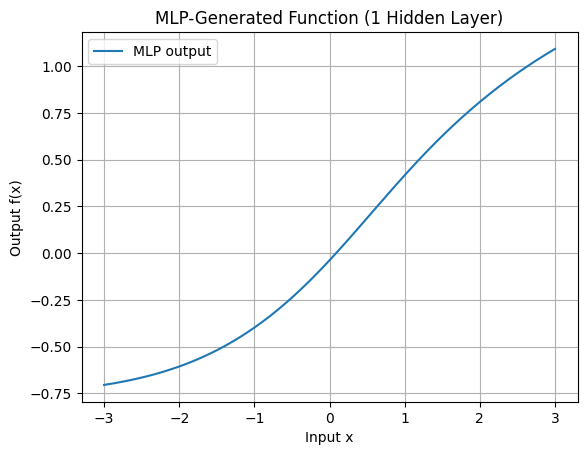

In [1]:
# Install PyTorch (if not already available in your Colab session)
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define a simple MLP with 1 hidden layer of 5 neurons
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 5),  # Input to hidden
            nn.Tanh(),        # Try ReLU too!
            nn.Linear(5, 1)   # Hidden to output
        )

    def forward(self, x):
        return self.net(x)

# Create the model and disable gradient tracking (inference only)
mlp = SimpleMLP()
mlp.eval()

# Generate 1D inputs from -3 to 3
x = torch.linspace(-3, 3, 300).unsqueeze(1)
with torch.no_grad():
    y = mlp(x)

# Plot the resulting function
plt.plot(x.numpy(), y.numpy(), label="MLP output")
plt.title("MLP-Generated Function (1 Hidden Layer)")
plt.xlabel("Input x")
plt.ylabel("Output f(x)")
plt.grid(True)
plt.legend()
plt.show()

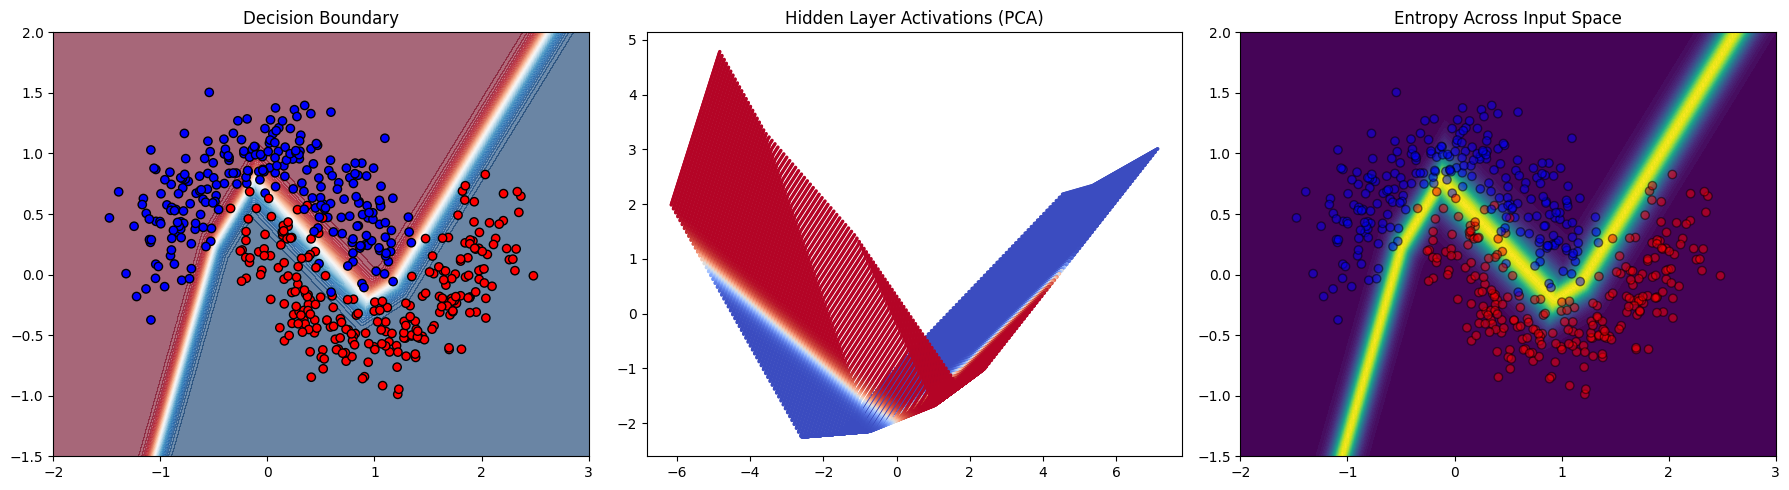

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generate 2D toy dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define tiny neural net
class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 2)

    def forward(self, x):
        z1 = self.fc1(x)
        a1 = F.relu(z1)
        z2 = self.fc2(a1)
        return z2, z1, a1

# Initialize + train
model = TinyNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(200):
    logits, _, _ = model(X_train)
    loss = loss_fn(logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Grid over input space
xx, yy = torch.meshgrid(torch.linspace(-2, 3, 200), torch.linspace(-1.5, 2, 200), indexing='ij')
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Run model over grid
with torch.no_grad():
    logits, z1, a1 = model(grid)
    probs = F.softmax(logits, dim=1)
    entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)

# Reshape for plotting
Z = probs[:, 1].reshape(xx.shape)
E = entropy.reshape(xx.shape)

# Plot everything
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Original data and decision boundary
axs[0].contourf(xx, yy, Z.numpy(), levels=50, cmap="RdBu", alpha=0.6)
axs[0].scatter(X[:,0], X[:,1], c=y, cmap="bwr", edgecolor="k")
axs[0].set_title("Decision Boundary")

# 2. First-layer activations (projected to 2D via PCA)
from sklearn.decomposition import PCA
a1_np = a1.numpy()
pca = PCA(n_components=2)
proj = pca.fit_transform(a1_np)
axs[1].scatter(proj[:,0], proj[:,1], c=Z.flatten().numpy(), cmap="coolwarm", s=2)
axs[1].set_title("Hidden Layer Activations (PCA)")

# 3. Entropy heatmap
axs[2].contourf(xx, yy, E.numpy(), levels=50, cmap="viridis")
axs[2].scatter(X[:,0], X[:,1], c=y, cmap="bwr", edgecolor="k", alpha=0.5)
axs[2].set_title("Entropy Across Input Space")

plt.tight_layout()
plt.show()